In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
import pandas as pd
import seaborn as sns
from matplotlib.animation import FuncAnimation

from neutrons.diffusing_neutrons import DiffusingNeutrons, Tank, Vector, Parameters
from neutrons.post_measure import Measurer
from neutrons.models.maxwell_boltzmann import MaxwellBoltzmann

/tmp/ipykernel_33388/2589873346.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def plot_trajectories(positions: list[list[Vector]], tank: None | Tank):

    radius = tank.radius
    height = tank.height
    tank_position = tank.position


    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    
    if tank is not None:
        ax.plot([-radius + tank_position[0], -radius + tank_position[0]], [tank_position[1], tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        ax.plot([tank_position[0], tank_position[0]], [radius + tank_position[1], radius + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")

    for position in positions:
        x = [p[0] for p in position]
        y = [p[1] for p in position]
        z = [p[2] for p in position]
        ax.plot(x, y, z, c="k", linewidth=1, alpha=0.5)

    ax.plot(0, 0, 0, "o", c="r")
    ax.set_xlabel("$x(m)$", fontsize=16)
    ax.set_ylabel("$y(m)$", fontsize=16)
    ax.set_box_aspect(aspect=None, zoom=0.9)
    ax.set_zlabel("$z(m)$", fontsize=16)
    ax.set_title("Neutron trajectories")
    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(-0.4, 0.4)
    
    if tank is not None:
        ax.plot([0 + tank_position[0], 0 + tank_position[0]], [-radius + tank_position[1], -radius + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        ax.plot([radius + tank_position[0], radius + tank_position[0]], [0 + tank_position[1], 0 + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, height, 100)
        x = radius * np.outer(np.cos(u), np.ones_like(v)) + tank_position[0]
        y = radius * np.outer(np.sin(u), np.ones_like(v)) + tank_position[1]
        z = np.outer(np.ones_like(u), v) - height/2 + tank_position[2]  # Adjust the height of the cylinder
        ax.plot_surface(x, y, z, color="C0", alpha=0.2)
    plt.show()

In [3]:
params = Parameters(
            nNeutrons=10, 
            radius_tank=0.225, 
            height_tank=0.85, 
            position_tank=np.array([0, 0, -0.175])
            )

  0%|          | 0/10 [00:00<?, ?it/s]

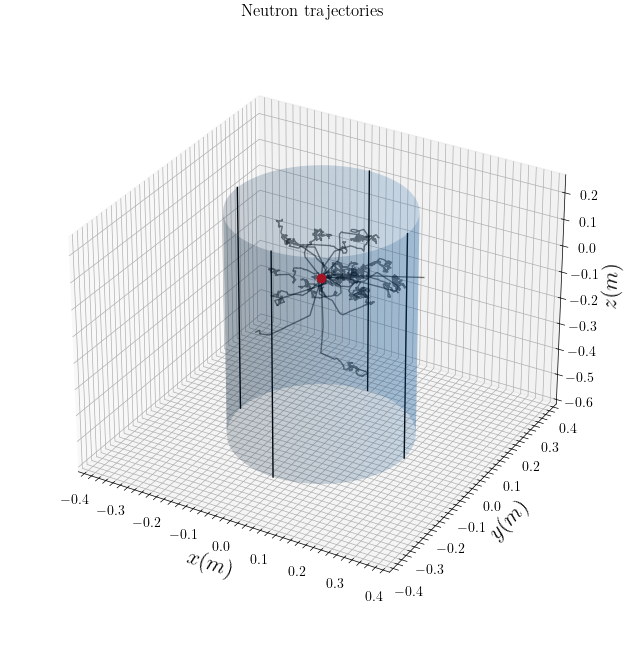

In [19]:
params.nNeutrons = 20
diffusing_neutrons = DiffusingNeutrons(params)
diffusing_neutrons.diffuse(nCollisions=1000000)

measure = Measurer(diffusing_neutrons)
plot_trajectories(measure.positions(), diffusing_neutrons.tank)


  0%|          | 0/14 [00:00<?, ?it/s]

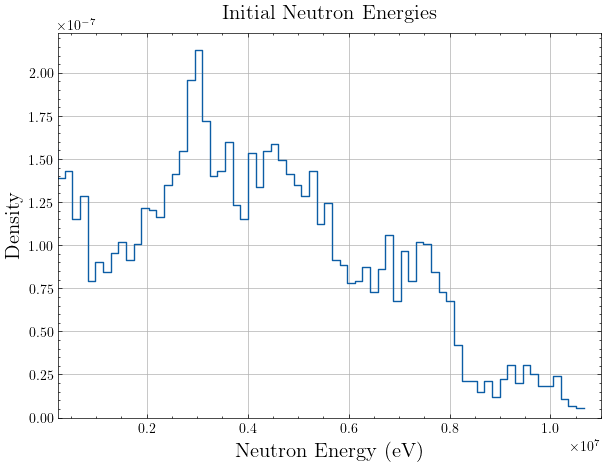

In [5]:
params.nNeutrons = 5000
diffusing_neutrons = DiffusingNeutrons(params)
diffusing_neutrons.diffuse(nCollisions=1000000)
measure = Measurer(diffusing_neutrons)

initial_energies = [energies[0] for energies in measure.energies()]

plt.figure(figsize= (7, 5))
sns.histplot(
    data=initial_energies, element="step", fill=False, stat="density", bins=70
)
plt.title("Initial Neutron Energies", fontsize=15, pad=10)
plt.ylabel("Density", fontsize=15)
plt.xlabel("Neutron Energy (eV)", fontsize=15)
plt.grid(True)
plt.xlim(10**5.4, 1.1*10**7)
plt.show()

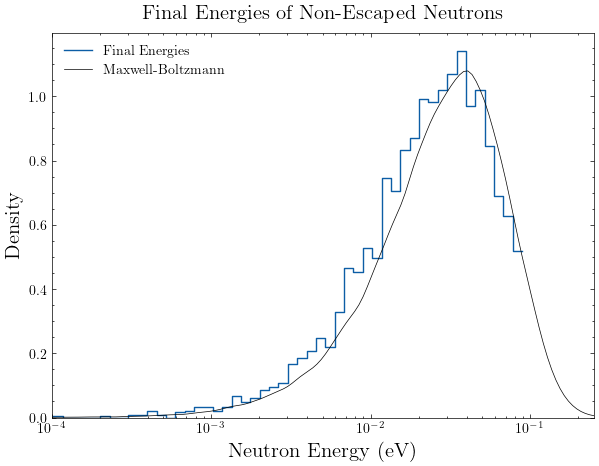

In [6]:
mw = MaxwellBoltzmann()

final_energies = [energies[-1] for energies in measure.energies()]
mw_energies = [mw.thermal_energy() for _ in range(100000)]
plt.figure(figsize= (7, 5))
plt.title("Final Energies of Non-Escaped Neutrons", fontsize=15, pad=10)
sns.histplot(
    data=sorted(final_energies)[:-measure.number_escaped()],
    log_scale=True, element="step", fill=False, stat="density", bins=50, label = "Final Energies"
)
sns.kdeplot(mw_energies, label="Maxwell-Boltzmann", color="k", log_scale=True, linewidth=0.5)
plt.xlim(10**-4, 10**-0.6)
plt.ylabel("Density", fontsize=15)
plt.xlabel("Neutron Energy (eV)", fontsize=15)
plt.legend()
plt.show()

In [7]:
params.nNeutrons = 10000
diffusing_neutrons = DiffusingNeutrons(params)
diffusing_neutrons.diffuse(nCollisions=5000)

  0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
measure = Measurer(diffusing_neutrons)

print(f"Total: {measure.number_total()}")
print(f"Thermal: {measure.number_thermal()}")
print(f"Absorbed: {measure.number_absorbed()}")
print(f"Escaped: {measure.number_escaped()}")


Total: 10000
Thermal: 9079
Absorbed: 8903
Escaped: 1097


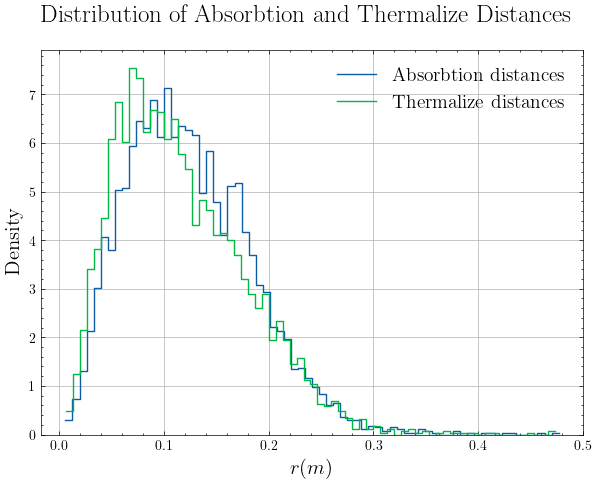

In [8]:
plt.figure(figsize=(7, 5))

sns.histplot(measure.absorbed_distances(), label="Absorbtion distances", bins=70, stat="density", fill=False, element="step")
sns.histplot(measure.thermalize_distances(), label="Thermalize distances", bins=70, stat="density", fill=False, element="step")
plt.ylabel("Density", fontsize=15)
plt.xlabel("$r (m)$", fontsize=15)
#axs[0].set_xlim(0, diffusing_neutrons.tank.radius+0.01)
plt.grid(True)
plt.title("Distribution of Absorbtion and Thermalize Distances", fontsize=18, pad=20, loc="left")
plt.legend(fontsize=14)

plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

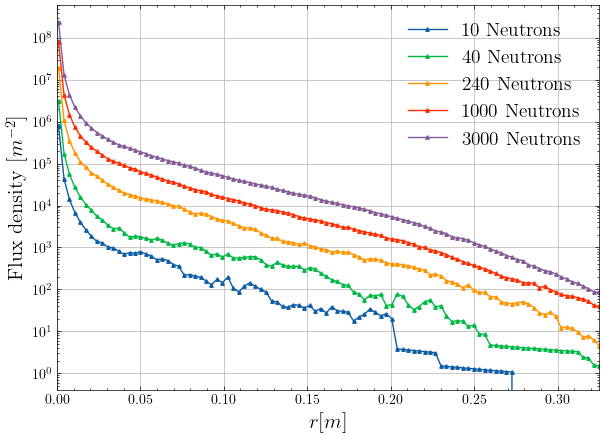

In [9]:
plt.figure(figsize= (7, 5))

for n in [10, 40, 240, 1000, 3000]:
    params.nNeutrons = n
    diffusing_neutrons = DiffusingNeutrons(params)
    diffusing_neutrons.diffuse(nCollisions=5000)
    measure = Measurer(diffusing_neutrons)
    radii = np.linspace(0.001, diffusing_neutrons.tank.radius+0.1, 100)
    fluxes = [measure.flux(r) for r in radii]

    plt.plot(radii, fluxes, "-^", markersize=2.5, label = f"{n} Neutrons")
plt.ylabel("Flux density [$m^{-2}$]", fontsize=15)
plt.xlabel("$r [m]$", fontsize=15)
plt.grid(True)
plt.yscale("log")
plt.xlim(0, diffusing_neutrons.tank.radius+0.1)
plt.legend(fontsize=14)
plt.show()

In [10]:
params.nNeutrons = 50000
diffusing_neutrons = DiffusingNeutrons(params)
diffusing_neutrons.diffuse(nCollisions=5000)

  0%|          | 0/14 [00:00<?, ?it/s]

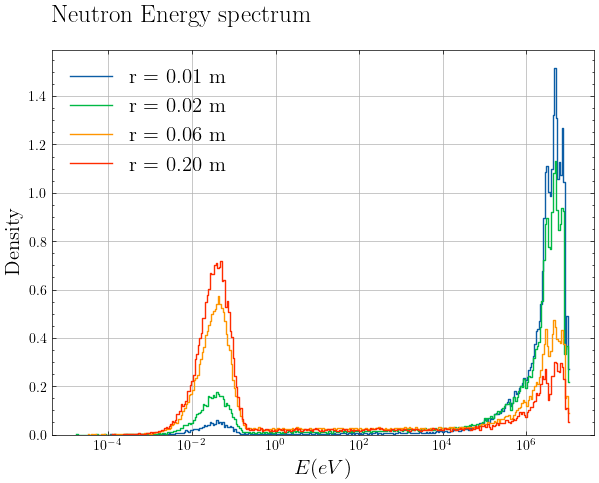

In [11]:
measure = Measurer(diffusing_neutrons)
plt.figure(figsize= (7, 5))
radii = [0.01, 0.02, 0.06, 0.2]

for radius in radii:
    sns.histplot(
    data=measure.energy_spectrum(r=radius),
    log_scale=True, element="step", fill=False, stat="density", bins=300, label = f"r = {radius:.2f} m"
)
plt.ylabel("Density", fontsize=15)
plt.xlabel("$E (eV)$", fontsize=15)

plt.title("Neutron Energy spectrum", fontsize=18, pad=20, loc="left")
plt.legend(fontsize=15)
plt.grid(True)
plt.show()


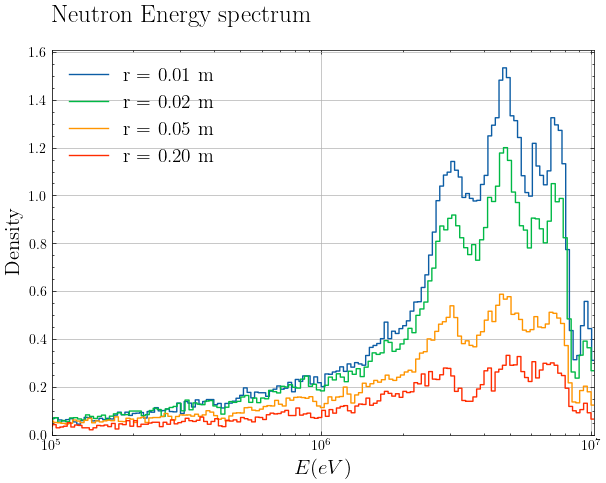

In [12]:
plt.figure(figsize= (7, 5))
radii = [0.01, 0.02, 0.05, 0.2]
for radius in radii:
    sns.histplot(
    data=measure.energy_spectrum(r=radius),
    log_scale=True, element="step", fill=False, stat="density", bins=800, label = f"r = {radius:.2f} m"
)
plt.ylabel("Density", fontsize=15)
plt.xlabel("$E (eV)$", fontsize=15)

plt.xlim(10**5, 10**7.01)
plt.title("Neutron Energy spectrum", fontsize=18, pad=20, loc="left")
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

In [15]:
measure = Measurer(diffusing_neutrons)
radii = np.linspace(0.001, diffusing_neutrons.tank.radius, 50)

fig, (ax, ax2) = plt.subplots(1,2, sharey=True, figsize=(12, 5))

def update(i):
    ax.clear()
    ax2.clear()
    radius = radii[i]
    sns.histplot(
        data=measure.energy_spectrum(r=radius),
        log_scale=True, element="step", fill=False, stat="density", bins=800, label = f"r = {radius:.2f} m",
        ax=ax
    )
    sns.histplot(
        data=measure.energy_spectrum(r=radius),
        log_scale=True, element="step", fill=False, stat="density", bins=800, label = f"r = {radius:.2f} m",
        ax=ax2
    )
    ax.set_xlim(10**-3, 10**0.01)
    ax2.set_xlim(10**4, 10**7.1)
    ax.set_ylim(0, 2.3)
    ax2.set_ylim(0, 2.3)

    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.yaxis.tick_right()

    ax.set_ylabel("Density", fontsize=15)
    ax.set_xlabel("$E (eV)$", fontsize=15)
    
    ax.set_title("Neutron Energy spectrum", fontsize=18, pad=20, loc="left")
    ax.legend(fontsize=17)
    ax.grid(True)
    ax2.grid(True)
    fig.subplots_adjust(wspace=0.1)

# Assign the FuncAnimation object to a variable at the global scope
ani = FuncAnimation(fig, update, frames=len(radii), repeat=True)

ani.save('neutron_energy_spectrum.gif')

plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


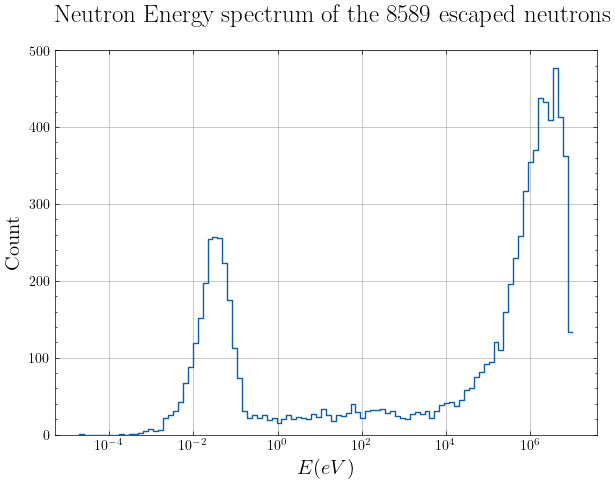

In [13]:
plt.figure(figsize= (7, 5))
sns.histplot(
    data=measure.energy_spectrum_escaped(),
    log_scale=True, element="step", fill=False, stat="count", bins=100
)
plt.ylabel("Count", fontsize=15)
plt.xlabel("$E (eV)$", fontsize=15)

#plt.xlim(10**5, 10**7.01)
plt.title(f"Neutron Energy spectrum of the {measure.number_escaped()} escaped neutrons", fontsize=18, pad=20, loc="left")
plt.grid(True)
plt.show()